In [ ]:
import os

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
jax.config.update("jax_enable_x64", False)
# jax.config.update("jax_platform_name", "gpu")

import functools
from typing import Callable, Optional

from tqdm.notebook import tqdm, trange
import equinox as eqx

import jax.numpy as jnp
import numpy as np
import optax
from jaxtyping import Array, PyTree, Int, Float, Complex, PRNGKeyArray

import netket as nk
from netket.operator import FermionOperator2ndJax
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

from netket.experimental.driver import VMC_SRt
from netket.jax import logdet_cmplx
jax.config.update("jax_enable_x64", False)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
key = jax.random.key(0)

## Construct Hilbert spaces and Hamiltonian operator
- Hilbertspace
\begin{equation}
    \mathcal H = \operatorname{span}\{\ket{n}:n \in \mathcal L(L_x, L_y, ...)\},\quad F_{-} (\mathcal H) = \bigoplus_{n=0}^\infty S_{-}\mathcal H^{\otimes n}
\end{equation}
Where $\mathcal L(L_x, L_y, ...)$ is square lattice with lengths $L_x, L_y, ...$.


- Hamiltonian operator
\begin{equation}
    H=-t\sum_{\braket{\mathbf r, \mathbf r'}, \sigma} [c_{\sigma}^\dagger(\mathbf r')c_{\sigma}(\mathbf r) + c_{\sigma}^\dagger(\mathbf r)c_{\sigma}(\mathbf r')] + U\sum_{\mathbf r} n_\uparrow (\mathbf r) n_\downarrow (\mathbf r)
\end{equation}


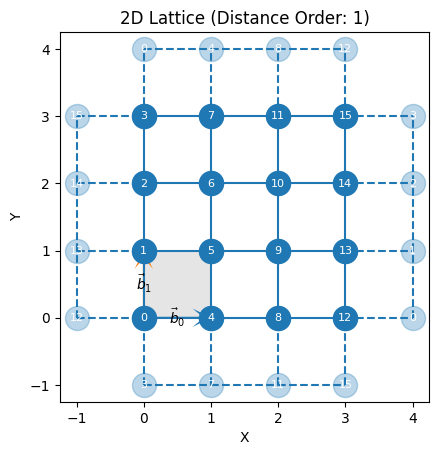

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [ ]:
def construct_system(t: float, U: float, N: int, L: list[int], pbc=True) -> tuple[nk.hilbert.SpinOrbitalFermions, FermionOperator2ndJax]:
    hi = nk.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions=N)
    H = FermionOperator2ndJax(hi)

    graph = nk.graph.Grid(L, pbc=pbc)
    for (r1, r2) in graph.edges():
        for s in [-1, 1]:
            H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

    for r in graph.nodes():
        H += U * nc(hi, r, -1) * nc(hi, r, 1)

    return hi, H

t = 1.0
U = 8.0
N = 52
L = [8, 8]
PBC = True

graph = nk.graph.Grid(L, pbc=PBC)
graph_extended = nk.graph.disjoint_union(graph, graph)

graph.draw()

In [3]:
hi = nk.hilbert.SpinOrbitalFermions(graph.n_nodes, s=1/2, n_fermions=N)

H = FermionOperator2ndJax(hi)
for (r1, r2) in graph.edges():
    for s in [-1, 1]:
        H += -t * (cdag(hi, r1, s) * c(hi, r2, s) + cdag(hi, r2, s) * c(hi, r1, s))

for r in graph.nodes():
    H += U * nc(hi, r, -1) * nc(hi, r, 1)

## Exact Diagonalization

As a reference

In [4]:
# sp_h = H.to_numba_operator().to_sparse()

In [ ]:
# from scipy.sparse.linalg import eigsh

# eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

# E_gs = eig_vals[0]

# print("Exact ground state energy:", E_gs)
E_gs = -0.75 * 64
print("expected Ground State Energy:", E_gs)

## Mean-Field Slater Determinant

\begin{equation}
    \ket{\Phi_s}=\prod_{\alpha=1}^{N_{\mathrm f}}\phi_\alpha^\dagger\ket{0}
\end{equation}

Where $\ket{0}$ is the vacuum state and the single-particle orbitals are created by the operators $\phi_\alpha^\dagger$. In turn, these creation operators are, in general, a linear combination of the original creation operators:
\begin{equation}
    \phi_\alpha^\dagger =\sum_{i} M_{\alpha, i}c_i^\dagger
\end{equation}
The rectangular $(N\times N_{\mathrm f})$ matrix $M$ constitutes a set of free variational parameters (Where $N$ is the number of orbitals and $N_{\mathrm f}$ the number of fermions).

It can be shown that the amplitudes of the wave function in the computational basis $\ket{n_1, ..., n_N}$ are determinants:
\begin{equation}
    \braket{n_1, ..., n_N|\Phi_{s}} = \det\{A(n)\}
\end{equation}
where the $N_{\mathrm f}\times N_{\mathrm f}$ matrix is
\begin{equation}
    A(n)_{\alpha,\beta} = M_{R_\alpha(\mathbf n), \beta},
\end{equation}
where $R_\alpha(\mathbf n)$ denotes the index of the $\alpha$-th occupied site (non-zero $n_i$) in $\mathbf n=(n_1, ..., n_N)$. This can also be interepted as selecting $N_{\mathrm f}$ rows of the matrix $M$ in corresponding to the $N_{\mathrm f}$ occupied orbitals. For more details see Chapter 5 of Reference [1].

To write down this variational amplitudes, we start by defining a convenience function to compute the logarithm of the determinant of a matrix, in the complex domain, and using jax:

In [6]:
@jax.jit
def nkstate_to_indexseq(
    state,
) -> jnp.ndarray:
    return jnp.nonzero(state, size=hi.n_fermions)

def count_parameters(model):
    leaves = jax.tree.leaves(model)
    return sum(x.size for x in leaves if isinstance(x, jnp.ndarray))

class BatchWrapper(eqx.Module):
    submodule: eqx.Module

    def __init__(self, submodule):
        self.submodule = submodule

    def __call__(self, batch, **kwargs):
        outputs = jax.vmap(self.submodule)(batch)
        return outputs

### Simplest Slater Determinant

In [7]:
class LogSlaterDeterminant(eqx.Module):
    embedding: eqx.nn.Embedding

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        *,
        key: PRNGKeyArray
    ):
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=key)

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        return logdet_cmplx(A)

In [8]:
key, subkey = jax.random.split(key)
sd_model = LogSlaterDeterminant(hi, key=subkey)
sd_batched = BatchWrapper(
    sd_model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
count_parameters(sd_batched)

448

In [ ]:
sd_vstate = nk.vqs.MCState(sa, sd_batched, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**11)

In [10]:
sd_vstate.samples.shape

(16, 256, 32)

In [11]:
sd_vstate.samples[0,0]

Array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int8)

In [ ]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.01)

# Create the VMC (Variational Monte Carlo) driver
# gs = nk.VMC(H, op, variational_state=sd_vstate, preconditioner=preconditioner)
gs = VMC_SRt(H, op, variational_state=sd_vstate, diag_shift=0.01)

In [ ]:
# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=slater_log)

  0%|          | 0/200 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [14]:
energy = sd_vstate.expect(H)
error = abs((energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.922-0.000j ± 0.056 [σ²=6.580, R̂=1.0549]
Relative error   : 0.24645578861236572


### Neural Jastrow

In [15]:
class LogNeuralJastrowSlater(eqx.Module):
    embedding: eqx.nn.Embedding
    jastrow_linear: eqx.nn.Linear

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        hidden_size: int,
        *,
        key: PRNGKeyArray
    ):
        embedding_key, jastrow_key = jax.random.split(key, 2)
        self.embedding = eqx.nn.Embedding(hilbert.size, hilbert.n_fermions, key=embedding_key)
        self.jastrow_linear = eqx.nn.Linear(
            hilbert.size,
            hidden_size,
            key=jastrow_key
        )

    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        A = jax.vmap(self.embedding)(indices)
        J = self.jastrow_linear(state)
        J = jax.nn.tanh(J)
        J = jnp.sum(J)

        return logdet_cmplx(A) + J

In [ ]:
key, subkey = jax.random.split(key)
nj_model = LogNeuralJastrowSlater(
    hilbert=hi,
    hidden_size=hi.size,
    key=subkey
)
nj_batched = BatchWrapper(
    nj_model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
nj_vstate = nk.vqs.MCState(sa, nj_batched, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**11)
count_parameters(nj_model)

1504

In [ ]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.01)

# Create the VMC (Variational Monte Carlo) driver
# gs = nk.VMC(H, op, variational_state=nj_vstate, preconditioner=preconditioner)
gs = VMC_SRt(H, op, variational_state=nj_vstate, diag_shift=0.01)

In [ ]:
 # Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

  0%|          | 0/200 [00:00<?, ?it/s]

2025-06-01 15:14:55.389522: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [19]:
energy = nj_vstate.expect(H)
error = abs((energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {energy}")
print(f"Relative error   : {error}")

Optimized energy : -11.092-0.000j ± 0.030 [σ²=3.361, R̂=1.0036]
Relative error   : 0.06316553801298141


### Self-Attention Ansatz

In [ ]:
class TransformerLayer(eqx.Module):
    attention: eqx.nn.MultiheadAttention
    up_proj: eqx.nn.Linear
    down_proj: eqx.nn.Linear
    ln1: eqx.nn.LayerNorm
    ln2: eqx.nn.LayerNorm
    activation: Callable

    def __init__(
        self,
        hidden_size: int,
        attention_size: int,
        num_head: int,
        intermediate_size: int,
        activation: Callable,
        *,
        key
    ):
        attention_key, up_proj_key, down_proj_key = jax.random.split(key, 3)
        self.attention = eqx.nn.MultiheadAttention(
            num_head,
            hidden_size,
            hidden_size,
            hidden_size,
            hidden_size,
            attention_size,
            attention_size,
            key=attention_key
        )
        self.up_proj = eqx.nn.Linear(
            hidden_size,
            intermediate_size,
            key=up_proj_key
        )
        self.down_proj = eqx.nn.Linear(
            intermediate_size,
            hidden_size,
            key=down_proj_key
        )
        self.ln1 = eqx.nn.LayerNorm(hidden_size)
        self.ln2 = eqx.nn.LayerNorm(hidden_size)
        self.activation = activation

    def __call__(
        self,
        x: Float[Array, "n h"]
    ):
        atten_out = self.attention(x, x, x)
        ff_in = jax.vmap(self.ln1)(atten_out + x)
        up_projected = jax.vmap(self.up_proj)(ff_in)
        up_projected = self.activation(up_projected)
        down_projected = jax.vmap(self.down_proj)(up_projected)
        return jax.vmap(self.ln2)(ff_in + down_projected)

class AttentionWFN(eqx.Module):
    embedding: eqx.nn.Embedding
    ln: eqx.nn.LayerNorm
    layers: tuple[TransformerLayer]
    projector: eqx.nn.Linear
    use_complex: bool=eqx.field(static=True)

    def __init__(
        self,
        hilbert: nk.hilbert.SpinOrbitalFermions,
        num_layers: int,
        hidden_size: int,
        attention_size: int,
        num_head: int,
        intermediate_size: int,
        activation: jax.nn.gelu,
        *,
        use_complex: bool=False,
        key: PRNGKeyArray
    ):
        embedding_key, attention_key, proj_key = jax.random.split(key, 3)
        self.embedding = eqx.nn.Embedding(hilbert.size, hidden_size, key=embedding_key)
        self.ln = eqx.nn.LayerNorm(hidden_size)
        attention_keys = jax.random.split(attention_key, num_layers)
        self.layers = tuple(
            TransformerLayer(
                hidden_size,
                attention_size,
                num_head,
                intermediate_size,
                activation,
                key=subkey
            )
            for subkey in attention_keys
        )
        out_size = 2 * hilbert.n_fermions if use_complex else hilbert.n_fermions
        self.projector = eqx.nn.Linear(hidden_size, out_size, key=proj_key)
        self.use_complex = use_complex


    def __call__(
        self,
        state: Int[Array, "hilb_size"]
    ) -> Complex[Array, ""]:
        indices = nkstate_to_indexseq(state)[0]
        embedded = jax.vmap(self.embedding)(indices) # (n_fermions, hidden_size)
        embedded = jax.vmap(self.ln)(embedded)
        for layer in self.layers:
            embedded = layer(embedded)
        projected = jax.vmap(self.projector)(embedded)
        if self.use_complex:
            real, imag = jnp.split(projected, 2, axis=1)
            projected = jax.lax.complex(real, imag)
        return logdet_cmplx(projected)

In [ ]:
key, subkey = jax.random.split(key)
at_model = AttentionWFN(
    hilbert=hi,
    num_layers=1,
    hidden_size=64,
    attention_size=64,
    num_head=1,
    intermediate_size=64,
    activation=jax.nn.mish,
    use_complex=False,
    key=subkey
)
at_batched = BatchWrapper(
    at_model
)
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph_extended)
sa_vstate = nk.vqs.MCState(sa, at_batched, n_samples=2**12, n_discard_per_chain=16, chunk_size=2**11)
count_parameters(at_model)

36174

In [ ]:
# op = nk.optimizer.Adam(learning_rate=0.001)
# gs = nk.VMC(H, op, variational_state=sa_vstate)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.01)

# Create the VMC (Variational Monte Carlo) driver
# gs = nk.VMC(H, op, variational_state=sa_vstate, preconditioner=preconditioner)
gs = VMC_SRt(H, op, variational_state=sa_vstate, diag_shift=0.01)

In [ ]:
# Construct the logger to visualize the data later on
atten_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=atten_log)

  0%|          | 0/200 [00:00<?, ?it/s]

2025-06-01 17:12:52.333272: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-01 17:12:52.333307: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-01 17:12:52.333315: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-01 17:12:52.333321: W external/xla/xla/service/gpu/au

In [ ]:
energy = sa_vstate.expect(H)
error = abs((energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {energy}")
print(f"Relative error   : {error}")

Optimized energy : -11.235+0.000j ± 0.065 [σ²=3.955, R̂=1.1972]
Relative error   : 0.05109962821006775


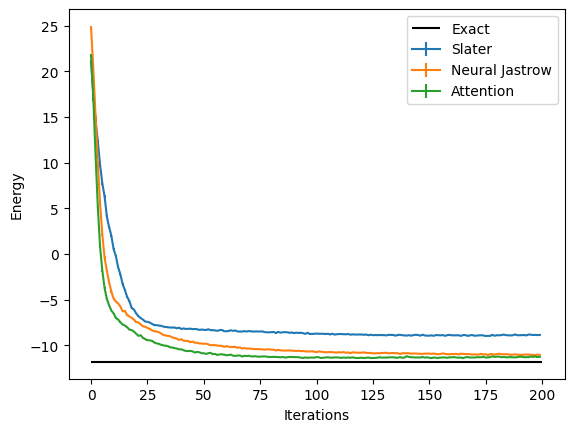

In [ ]:
logged_data = (slater_log.data, nj_log.data, atten_log.data)
labels = ("Slater","Neural Jastrow","Attention")

for data, label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

# plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

### Lattice util

In [26]:
def neighbourhoods_pbc(site: int, lattace: nk.graph.Lattice) -> tuple[int]:
    """Return the indices of up down left right"""
    Lx, Ly = lattace.extent
    L = np.array([Lx, Ly, 1])
    up = np.array([0, 1, 0])
    down = np.array([0, -1, 0])
    left = np.array([-1, 0, 0])
    right = np.array([1, 0, 0])
    coord = lattace.sites[site].basis_coord
    
    up_coord = (coord + up) % L
    down_coord = (coord + down) % L
    left_coord = (coord + left) % L
    right_coord = (coord + right) % L
    
    up_id = lattace.id_from_basis_coords(up_coord)
    down_id = lattace.id_from_basis_coords(down_coord)
    left_id = lattace.id_from_basis_coords(left_coord)
    right_id = lattace.id_from_basis_coords(right_coord)
    return up_id, down_id, left_id, right_id

### 1-point correlators

In [54]:
def density(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    return nc(hilbert, site, 1) + nc(hilbert, site, -1)

def double_occupancy(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    return nc(hilbert, site, 1) * nc(hilbert, site, -1)

def sz(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    c_up = c(hilbert, site, 1)
    c_down = c(hilbert, site, -1)
    c_up_dag = cdag(hilbert, site, 1)
    c_down_dag = cdag(hilbert, site, -1)
    
    return 0.5 * (c_up_dag * c_up - c_down_dag * c_down)

def sx(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    c_up = c(hilbert, site, 1)
    c_down = c(hilbert, site, -1)
    c_up_dag = cdag(hilbert, site, 1)
    c_down_dag = cdag(hilbert, site, -1)
    
    return 0.5 * (c_up_dag * c_down + c_down_dag * c_up)

def sy(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    c_up = c(hilbert, site, 1)
    c_down = c(hilbert, site, -1)
    c_up_dag = cdag(hilbert, site, 1)
    c_down_dag = cdag(hilbert, site, -1)
    
    return -0.5j * (c_up_dag * c_down - c_down_dag * c_up)


def spin(hilbert: nk.hilbert.SpinOrbitalFermions, site: int) -> FermionOperator2ndJax:
    c_up = c(hilbert, site, 1)
    c_down = c(hilbert, site, -1)
    c_up_dag = cdag(hilbert, site, 1)
    c_down_dag = cdag(hilbert, site, -1)
    
    spin_x = 0.5 * (c_up_dag * c_down + c_down_dag * c_up)
    spin_y = -0.5j * (c_up_dag * c_down - c_down_dag * c_up)
    spin_z = 0.5 * (c_up_dag * c_up - c_down_dag * c_down)
    return (spin_x, spin_y, spin_z)

### 2-point correleators

In [56]:
def density_density(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site1: int,
    site2: int
) -> FermionOperator2ndJax:
    return density(hilbert, site1) * density(hilbert, site2)

def sz_sz(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site1: int,
    site2: int
) -> FermionOperator2ndJax:
    _, _, sz1 = spin(hilbert, site1)
    _, _, sz2 = spin(hilbert, site2)
    return sz1 * sz2

def spin_spin(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site1: int,
    site2: int
) -> FermionOperator2ndJax:
    sx1, sy1, sz1 = spin(hilbert, site1)
    sx2, sy2, sz2 = spin(hilbert, site2)
    return (sx1 * sx2 + sy1 * sy2 + sz1 * sz2)

### pairing correlator

In [57]:
def delta_s(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    up_site, down_site, left_site, right_site = neighbourhoods_pbc(site, lattice)
    op = FermionOperator2ndJax(hilbert)
    op += c(hilbert, site, 1) * c(hilbert, up_site, -1) - c(hilbert, site, -1) * c(hilbert, up_site, 1)
    op += c(hilbert, site, 1) * c(hilbert, down_site, -1) - c(hilbert, site, -1) * c(hilbert, down_site, 1)
    op += c(hilbert, site, 1) * c(hilbert, left_site, -1) - c(hilbert, site, -1) * c(hilbert, left_site, 1)
    op += c(hilbert, site, 1) * c(hilbert, right_site, -1) - c(hilbert, site, -1) * c(hilbert, right_site, 1)
    return op

def delta_s_dag(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    up_site, down_site, left_site, right_site = neighbourhoods_pbc(site, lattice)
    op = FermionOperator2ndJax(hilbert)
    op += cdag(hilbert, up_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, up_site, 1) * cdag(hilbert, site, -1)
    op += cdag(hilbert, down_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, down_site, 1) * cdag(hilbert, site, -1)
    op += cdag(hilbert, left_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, left_site, 1) * cdag(hilbert, site, -1)
    op += cdag(hilbert, right_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, right_site, 1) * cdag(hilbert, site, -1)
    return op

def delta_d(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    up_site, down_site, left_site, right_site = neighbourhoods_pbc(site, lattice)
    op = FermionOperator2ndJax(hilbert)
    op += -(c(hilbert, site, 1) * c(hilbert, up_site, -1) - c(hilbert, site, -1) * c(hilbert, up_site, 1))
    op += -(c(hilbert, site, 1) * c(hilbert, down_site, -1) - c(hilbert, site, -1) * c(hilbert, down_site, 1))
    op += c(hilbert, site, 1) * c(hilbert, left_site, -1) - c(hilbert, site, -1) * c(hilbert, left_site, 1)
    op += c(hilbert, site, 1) * c(hilbert, right_site, -1) - c(hilbert, site, -1) * c(hilbert, right_site, 1)
    return op

def delta_d_dag(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    up_site, down_site, left_site, right_site = neighbourhoods_pbc(site, lattice)
    op = FermionOperator2ndJax(hilbert)
    op += -(cdag(hilbert, up_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, up_site, 1) * cdag(hilbert, site, -1))
    op += -(cdag(hilbert, down_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, down_site, 1) * cdag(hilbert, site, -1))
    op += cdag(hilbert, left_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, left_site, 1) * cdag(hilbert, site, -1)
    op += cdag(hilbert, right_site, -1) * cdag(hilbert, site, 1) - cdag(hilbert, right_site, 1) * cdag(hilbert, site, -1)
    return op

def pairing_s(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site1: int,
    site2: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    return delta_s_dag(hilbert, site2, lattice) * delta_s(hilbert, site1, lattice)

def pairing_d(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    site1: int,
    site2: int,
    lattice: nk.graph.Lattice
) -> FermionOperator2ndJax:
    return delta_d_dag(hilbert, site2, lattice) * delta_d(hilbert, site1, lattice)
    

### getting attention 

In [ ]:
model = sa_vstate.model.submodule
embedding = model.embedding
attention = model.layers[0].attention

def attention_weights(
    mha: eqx.nn.MultiheadAttention,
    q: Float[Array, "Nq H"],
    k: Float[Array, "Nk H"]
):
    query_heads = mha._project(mha.query_proj, k)
    key_heads = mha._project(mha.key_proj, q)
    
    qk_size = mha.qk_size     # 각 헤드마다 사용할 차원
    num_heads = mha.num_heads # 헤드 수
    query_len = q.shape[0]
    key_len = k.shape[0]
    
    # reshape → (seq_len, num_heads, qk_size)
    Q = query_heads.reshape(query_len, num_heads, qk_size)
    K = key_heads.reshape(key_len, num_heads, qk_size)
    
    # head 차원을 앞으로 옮겨 → (num_heads, seq_len, qk_size)
    Q = jnp.transpose(Q, (1, 0, 2))
    K = jnp.transpose(K, (1, 0, 2))
    
    scale = 1.0 / jnp.sqrt(qk_size)
    # einsum: 각 헤드별로 (seq_len × qk_size) dot (qk_size × seq_len) → (seq_len × seq_len)
    scores = jnp.einsum("hqd,hkd->hqk", Q, K) * scale
    
    attention_weights = jax.nn.softmax(scores, axis=-1)
    
    return attention_weights

AttributeError: 'BatchWrapper' object has no attribute 'embedding'

## Visualizaion of Learned Correlation

In [61]:
from weakref import ref


def plot_matrices(
    matrices: Float[Array, "n m h w"],
    col_labels: list[str],
    row_labels: list[str],
    vmin: list[float],
    vmax: list[float]
):
    n_rows, n_cols, _, _ = matrices.shape

    # 전체 figure와 GridSpec 설정 (각 행마다 1개의 colorbar 열 추가)
    fig = plt.figure(figsize=(3 * n_cols + 0.5, 3 * n_rows))
    gs = GridSpec(
        n_rows,
        n_cols + 1,
        figure=fig,
        width_ratios=[1] * n_cols + [0.1],
        wspace=0.3,
        hspace=0.3
    )

    for i in range(n_rows):
        for j in range(n_cols):
            ax = fig.add_subplot(gs[i, j])

            # x→가로, y→세로로 표시하도록 전치하고 origin='lower' 설정
            mat = matrices[i, j].T
            im = ax.imshow(mat, cmap='bwr', vmin=vmin[i], vmax=vmax[i], origin='lower')

            # 첫 행인 경우에만 title (열 레이블)
            if i == 0:
                ax.set_title(col_labels[j], fontsize=10)
            # 첫 열인 경우에만 y-label (행 레이블)
            if j == 0:
                ax.set_ylabel(row_labels[i], fontsize=10)

            # 축 눈금만 제거
            ax.set_xticks([])
            ax.set_yticks([])

        # 각 행마다 마지막 열에 colorbar 추가
        cax = fig.add_subplot(gs[i, n_cols])
        cb = plt.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=6)

    plt.show()


def plot_1_point_2d(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    lattice: nk.graph.Lattice,
    vstates: list[nk.vqs.MCState],
    labels: list[str],
    corrs: list[Callable[[nk.hilbert.SpinOrbitalFermions, int], FermionOperator2ndJax]],
    corr_labels: list[str],
    corr_mins: Optional[list[float | None]] = None,
    corr_maxs: Optional[list[float | None]] = None
):
    Lx, Ly = lattice.extent
    n_rows = len(corrs)
    n_cols = len(vstates)

    data_matrices = np.zeros((n_rows, n_cols, Lx, Ly), dtype=np.float64)
    pbar = tqdm(total=n_rows * n_cols, desc="Calculating correlation matrices")
    for i, corr in enumerate(corrs):
        for j, vstate in enumerate(vstates):
            corr_arr = np.zeros((Lx, Ly), dtype=np.float64)
            for x in range(Lx):
                for y in range(Ly):
                    site = lattice.id_from_basis_coords((x, y, 0))
                    corr_op = corr(hilbert, site)
                    corr_arr[x, y] = vstate.expect(corr_op).mean.real

            data_matrices[i, j, :, :] = corr_arr
            pbar.update(1)
    pbar.close()

    vmins: list[float] = []
    vmaxs: list[float] = []
    for i in range(n_rows):
        row_data = data_matrices[i]
        row_min = row_data.min()
        row_max = row_data.max()

        if corr_mins is not None and corr_mins[i] is not None:
            vmins.append(corr_mins[i])
        else:
            vmins.append(row_min)

        if corr_maxs is not None and corr_maxs[i] is not None:
            vmaxs.append(corr_maxs[i])
        else:
            vmaxs.append(row_max)

    plot_matrices(
        matrices=data_matrices,
        col_labels=labels,
        row_labels=corr_labels,
        vmin=vmins,
        vmax=vmaxs
    )

def plot_2_point_2d(
    hilbert: nk.hilbert.SpinOrbitalFermions,
    lattice: nk.graph.Lattice,
    vstates: list[nk.vqs.MCState],
    labels: list[str],
    corrs: list[Callable[[nk.hilbert.SpinOrbitalFermions, int, int], FermionOperator2ndJax]],
    corr_labels: list[str],
    reference_site: tuple[int, int],
    corr_mins: Optional[list[float | None]] = None,
    corr_maxs: Optional[list[float | None]] = None
):
    Lx, Ly = lattice.extent
    n_rows = len(corrs)
    n_cols = len(vstates)

    data_matrices = np.zeros((n_rows, n_cols, Lx, Ly), dtype=np.float64)
    pbar = tqdm(total=n_rows * n_cols, desc="Calculating correlation matrices")
    for i, corr in enumerate(corrs):
        for j, vstate in enumerate(vstates):
            corr_arr = np.zeros((Lx, Ly), dtype=np.float64)
            for x in range(Lx):
                for y in range(Ly):
                    site = lattice.id_from_basis_coords((x, y, 0))
                    rx, ry = reference_site
                    ref_site = lattice.id_from_basis_coords((rx, ry, 0))
                    corr_op = corr(hilbert, site, ref_site)
                    corr_arr[x, y] = vstate.expect(corr_op).mean.real

            data_matrices[i, j, :, :] = corr_arr
            pbar.update(1)
    pbar.close()

    # 2) vmin/vmax 리스트 생성
    vmins: list[float] = []
    vmaxs: list[float] = []
    for i in range(n_rows):
        row_data = data_matrices[i]
        row_min = row_data.min()
        row_max = row_data.max()

        if corr_mins is not None and corr_mins[i] is not None:
            vmins.append(corr_mins[i])
        else:
            vmins.append(row_min)

        if corr_maxs is not None and corr_maxs[i] is not None:
            vmaxs.append(corr_maxs[i])
        else:
            vmaxs.append(row_max)

    # 3) 시각화 함수 호출
    plot_matrices(
        matrices=data_matrices,
        col_labels=labels,
        row_labels=corr_labels,
        vmin=vmins,
        vmax=vmaxs
    )

Calculating correlation matrices: 100%|██████████| 15/15 [00:00<00:00, 33.79it/s]


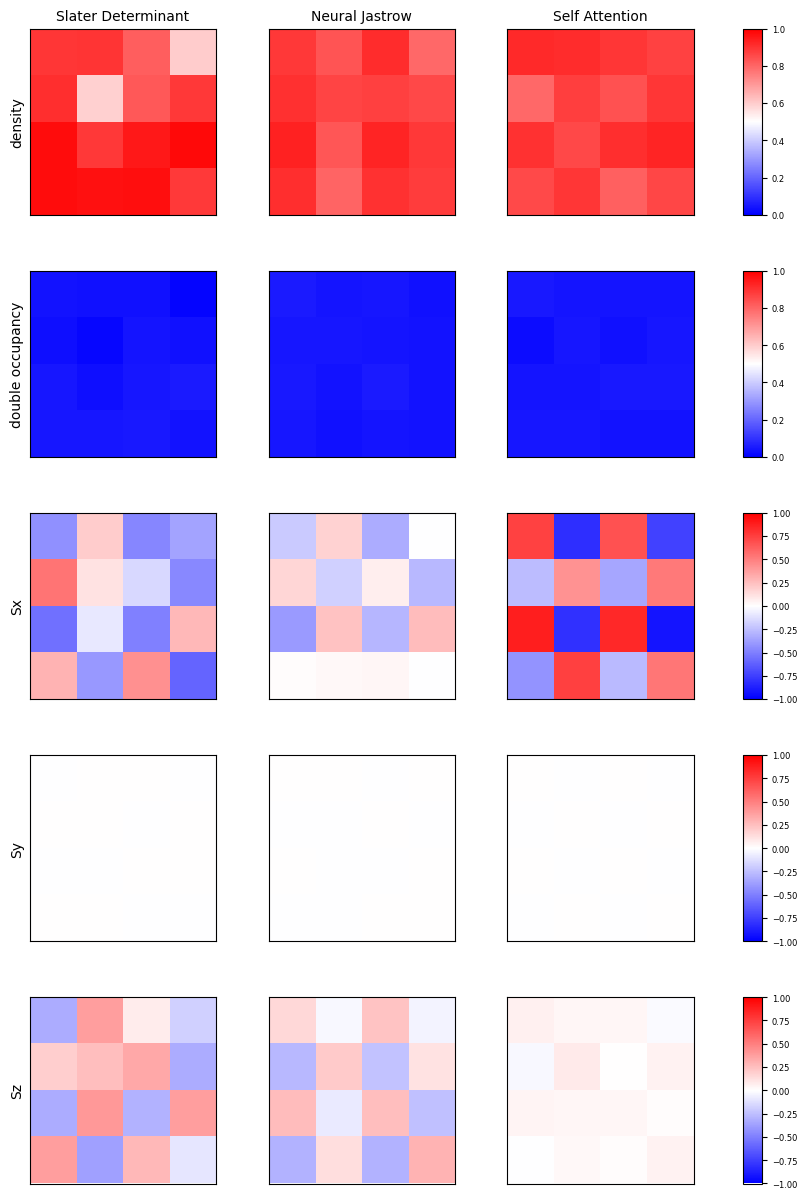

In [62]:
plot_1_point_2d(
    hi,
    graph,
    [sd_vstate, nj_vstate, sa_vstate],
    ["Slater Determinant", "Neural Jastrow", "Self Attention"],
    [density, double_occupancy, sx, sy, sz],
    ["density", "double occupancy", "Sx", "Sy", "Sz"],
    [0, 0, -1, -1, -1],
    [1, 1, 1, 1, 1]
)

Calculating correlation matrices: 100%|██████████| 9/9 [00:00<00:00, 18.64it/s]


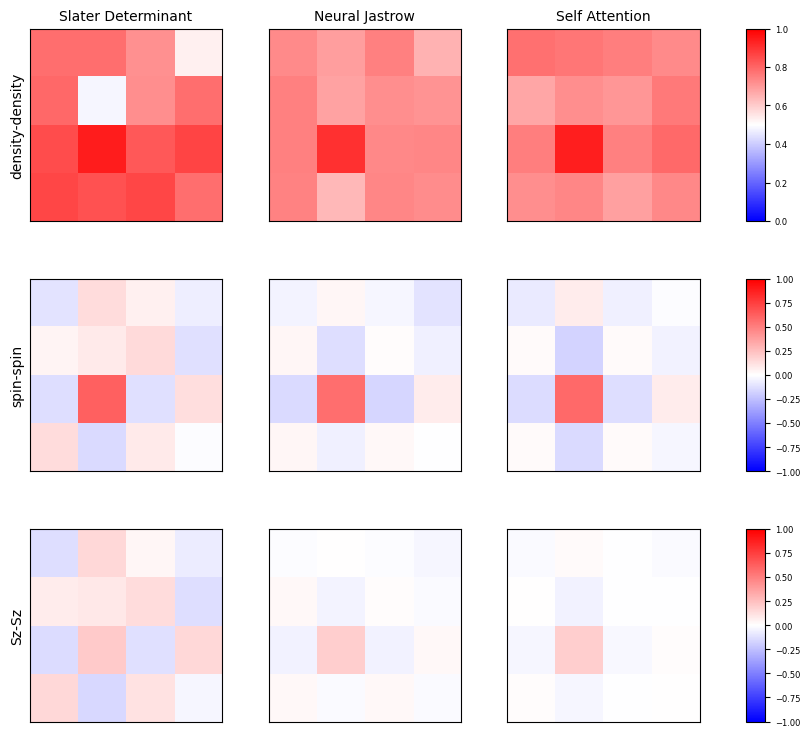

In [64]:
plot_2_point_2d(
    hi,
    graph,
    [sd_vstate, nj_vstate, sa_vstate],
    ["Slater Determinant", "Neural Jastrow", "Self Attention"],
    [density_density, spin_spin, sz_sz],
    ["density-density", "spin-spin", "Sz-Sz"],
    (1, 1),
    [0, -1, -1],
    [1, 1, 1]
)